# VisualMatch: Product Recommendation System Using Content-Based Image Retrieval (CBIR)

**VisualMatch** was a product recommendation system that utilized Content-Based Image Retrieval (CBIR) techniques to recommend similar products based on visual features. I employed deep learning for feature extraction using a pre-trained ResNet18 model and computed similarity between products using cosine similarity.

## 1. Dataset Preparation
I preprocessed and organized the dataset by resizing images to 224x224 and normalizing them using ImageNet statistics to align with the input format required by the ResNet18 model.

In [1]:
import os
import torch
from PIL import Image
import numpy as np
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Directory where images were stored (adjust the path as needed)
data_dir = "./images"

# Image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess images
def load_and_preprocess_images(img_dir):
    """Load and preprocess images from the specified directory.

    Args:
        img_dir (str): Path to the image directory.
    
    Returns:
        list: Preprocessed images.
        list: Corresponding image filenames.
    """
    images, image_names = [], []
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = preprocess(img)
        images.append(img)
        image_names.append(img_name)
    return images, image_names

# Load and preprocess the images
images, image_names = load_and_preprocess_images(data_dir)

# Move images to the specified device (e.g., GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images = [img.to(device) for img in images]

## 2. Feature Extraction
I used a pre-trained ResNet18 model from the torchvision library to extract feature vectors from the images. I removed the classification layer to obtain feature vectors for similarity measurement.

In [2]:
# Load pre-trained ResNet18 model and remove the classification layer
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Removed the classification layer
model = model.to(device)
model.eval()

# Function to extract feature vectors from images
def extract_features(images, model):
    """Extract feature vectors from the images using the provided model.

    Args:
        images (list): Preprocessed images.
        model (torch.nn.Module): Feature extraction model.
    
    Returns:
        list: Feature vectors for the images.
    """
    features = []
    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0)  # Add batch dimension
            feature = model(img)
            feature = feature.view(-1)  # Flatten the feature vector
            features.append(feature.cpu().numpy())  # Move feature to CPU and convert to NumPy
    return features

# Extract feature vectors for all images
features = extract_features(images, model)

/Users/vyomdevgan/ptorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vyomdevgan/ptorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Similarity Measurement
I computed cosine similarity between feature vectors to find images visually similar to the query image. The top K similar images were recommended.

In [3]:
# Function to recommend similar products based on cosine similarity
def recommend_similar_products(features, image_names, query_index, top_k=5):
    """Recommend top-K similar products based on cosine similarity.

    Args:
        features (list): Feature vectors for the images.
        image_names (list): Names of the images.
        query_index (int): Index of the query image.
        top_k (int, optional): Number of top recommendations to return. Defaults to 5.
    
    Returns:
        list: Recommended products with similarity scores.
    """
    query_feature = [features[query_index]]  # Get the feature vector of the query image
    similarities = cosine_similarity(query_feature, features)[0]  # Compute similarity
    indices = np.argsort(similarities)[::-1][1:top_k+1]  # Sort by similarity and get top-K
    recommended = [(image_names[i], similarities[i]) for i in indices]
    return recommended

# Test the recommendation system
query_index = 0  # Index of the query image
recommendations = recommend_similar_products(features, image_names, query_index)

# Print recommendations
print(f"Recommendations for {image_names[query_index]}:")
for idx, (name, score) in enumerate(recommendations):
    print(f"{idx+1}. {name} (Similarity: {score:.4f})")

Recommendations for 9733.jpg:
1. 10612.jpg (Similarity: 0.9337)
2. 13487.jpg (Similarity: 0.9237)
3. 8588.jpg (Similarity: 0.9220)
4. 8589.jpg (Similarity: 0.9220)
5. 26418.jpg (Similarity: 0.9212)


## 4. Displaying the Query Image and Recommendations
I visualized the query image and recommended images side by side using matplotlib.

Query Image:


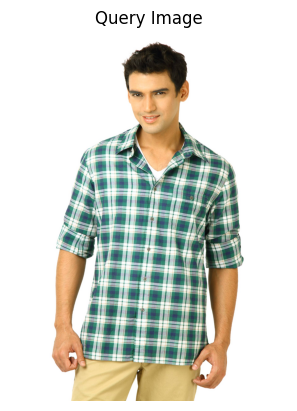

Recommended Images:


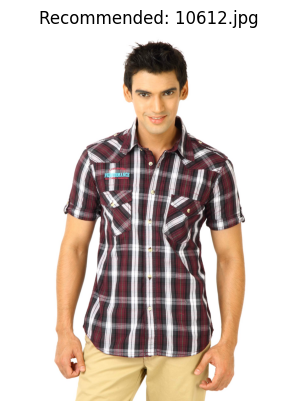

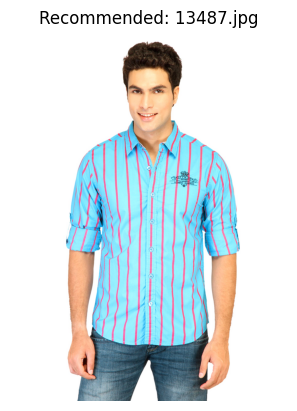

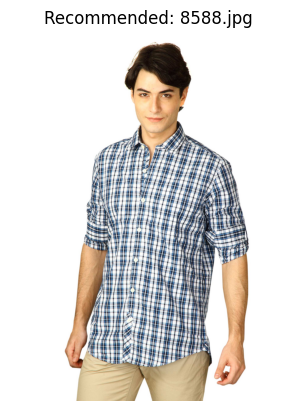

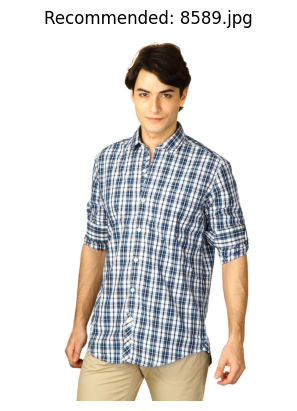

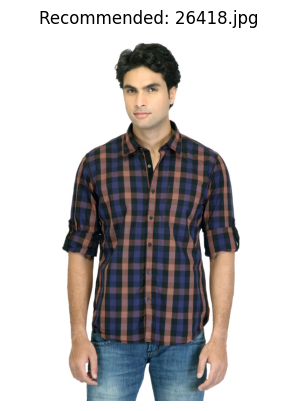

In [4]:
# Function to display an image with a title
def display_image(image_path, title=None):
    """Display an image with an optional title.

    Args:
        image_path (str): Path to the image file.
        title (str, optional): Title to display above the image. Defaults to None.
    """
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")  # Remove axis ticks and labels
    if title:
        plt.title(title)
    plt.show()

# Display the query image
print("Query Image:")
display_image(os.path.join(data_dir, image_names[query_index]), "Query Image")

# Display recommended images
print("Recommended Images:")
for name, _ in recommendations:
    display_image(os.path.join(data_dir, name), f"Recommended: {name}")